In [1]:
import numpy as np # Successfully installed numpy-1.23.5
import pandas as pd # Successfully installed pandas-1.3.5
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Dataset
from torch_geometric.data import Data
# the temporal package is not available TODO: find what the issue is
# from torch_geometric_temporal.nn.recurrent import A3TGCN2 # torch-geometric-temporal 0.54.0 requires pandas<=1.3.5, but you have pandas 2.2.3 which is incompatible.
#from torch_geometric_temporal.signal import temporal_signal_split
# import 
# Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
# from stellargraph import StellarGraph
# import custom functions from utils.py
# from utils import *
os.getcwd() # double check current working directory

'c:\\Users\\rober\\GitHub\\CAN-Graph\\notebooks'

In [2]:
# .. goes up one level in directory
path = r'../datasets/Car-Hacking Dataset/Fuzzy_dataset.csv'
path = r'../datasets/Car-Hacking Dataset/DoS_dataset.csv'
path = r'../datasets/Car-Hacking Dataset/gear_dataset.csv'
path = r'../datasets/Car-Hacking Dataset/RPM_dataset.csv'
df = pd.read_csv(path)
df.columns = ['Timestamp', 'CAN ID','DLC','Data1','Data2','Data3','Data4','Data5','Data6','Data7','Data8', 'label'] 

In [3]:
df

,Timestamp,CAN ID,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,1.478191e+09,018f,8,fe,3b,00,00,00,3c,00,00,R
1,1.478191e+09,0260,8,19,22,22,30,ff,8f,6e,3f,R
2,1.478191e+09,02a0,8,60,00,83,1d,96,02,bd,00,R
3,1.478191e+09,0329,8,dc,b8,7e,14,11,20,00,14,R
4,1.478191e+09,0545,8,d8,00,00,83,00,00,00,00,R
...,...,...,...,...,...,...,...,...,...,...,...,...
4621696,1.478201e+09,018f,8,fe,59,00,00,00,41,00,00,R
4621697,1.478201e+09,0260,8,18,21,21,30,08,8f,6d,19,R
4621698,1.478201e+09,02a0,8,24,00,9a,1d,97,02,bd,00,R
4621699,1.478201e+09,0329,8,dc,b7,7f,14,11,20,00,14,R


In [ ]:
'''
Temporal graph dataset: a graph that changes over time
Graph type: Homogeneous graph
Nodes: CAN ID
Edges: The next CAN ID in the sequence
Node Features (optional): The data in the CAN ID

Steps:
1. identify node properties
2. Edges: How to connect nodes?
3. Extract labels

Convert to pytorch geometric format
One graph to another graph: 200 messages to 1 graph

There is also pytorch geometric temporal package

# build a baseline model RF, SVM, etc

# fraud datasets may have incorrect labels -> use label smoothing
Featureless nodes: use random numbers

make a GCN that uses labels only, and one that takes an average of data form its neighbors as well
Graph Attention Networks (GAT)

Idea: could I use FL on the different car datasets, share those weights and perhaps it could generalize better. A practical use case would be between different companies, where they don't want to share their data
but it is in their best interest to have the best performing cybersecurity model.

https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.GNNExplainer.html
'''

In [4]:
df['Node'] = df['CAN ID']
df['Edge'] = df['CAN ID'].shift(-1)


In [8]:
# # Extract edge indices
edge_index = torch.tensor(df[['Node', 'Edge']].values, dtype=torch.long)

# # Extract node features (assuming features are in columns 'feature1', 'feature2', ..., 'featureN')
node_features = torch.tensor(df[['Data1','Data2','Data3','Data4','Data5','Data6','Data7','Data8',]].values, dtype=torch.float)

# # Create a Data object
data = Data(x=node_features, edge_index=edge_index)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [10]:
def create_graph(window_data, edge_index):
    x = torch.tensor(window_data, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

class TimeSeriesGraphDataset(Dataset):
    def __init__(self, time_series_data, window_size, stride):
        self.data = time_series_data
        self.window_size = window_size
        self.stride = stride
        self.graphs = self._create_graphs()

    def _create_graphs(self):
        graphs = []
        for i in range(0, len(self.data) - self.window_size + 1, self.stride):
            window = self.data[i:i+self.window_size]
            graph = create_graph(window, self._get_edge_index())
            graphs.append(graph)
        return graphs

    def _get_edge_index(self):
        # Define your edge creation logic here
        pass

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]

In [11]:
def create_graph(window_data, edge_index):
    x = torch.tensor(window_data, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

class TimeSeriesGraphDataset(Dataset):
    def __init__(self, time_series_data, window_size, stride):
        self.data = time_series_data
        self.window_size = window_size
        self.stride = stride
        self.graphs = self._create_graphs()

    def _create_graphs(self):
        graphs = []
        for i in range(0, len(self.data) - self.window_size + 1, self.stride):
            window = self.data[i:i+self.window_size]
            graph = create_graph(window, self._get_edge_index())
            graphs.append(graph)
        return graphs

    def _get_edge_index(self):
        # Define your edge creation logic here
        pass

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]

In [ ]:
'''' From GitHub Copilot
Key Attributes of the Data Class:
x: Node feature matrix with shape [num_nodes, num_node_features]. Each row corresponds to the feature vector of a node.
edge_index: Graph connectivity in COO format with shape [2, num_edges]. Each column represents an edge between two nodes.
edge_attr (optional): Edge feature matrix with shape [num_edges, num_edge_features]. Each row corresponds to the feature vector of an edge.
y (optional): Graph-level or node-level labels.
pos (optional): Node position matrix with shape [num_nodes, num_dimensions]. Useful for visualization or spatial graphs.
batch (optional): Batch vector, which assigns each node to a specific graph in a mini-batch.


'''
# label logic - if T in window then label is 1, else 0. Start simple and build out from there

dataset = TimeSeriesGraphDataset(df[['Node', 'Edge']], window_size=50, stride=1)

ValueError: could not determine the shape of object type 'DataFrame'

In [109]:
graph = df[['Node', 'Edge', 'label']].copy(deep=True)
color = {'R': 'blue',
         'NaN': 'blue',
         'T': 'red'}
graph['color'] = graph['label'].map(color)
# graph = graph[:-1] # omit last row as it doesn't have an edge (or just make it a blank connection)
# graph of the last 200 messages
graph_200 = graph[500:700]# create window size
#graph_200 = graph[1500:1700]
#graph_200 = graph[1450:1650]
# graph_200 = graph[2100:2300]
graph_200 = graph[1700:1900]
graph_200['color'] = graph_200['color'].fillna('blue')   
# graph_200 = graph[:-200] # create window size

C:\Users\rober\AppData\Local\Temp\ipykernel_26064\4130253898.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_200['color'] = graph_200['color'].fillna('blue')


In [110]:
graph['label'].value_counts()

label
R    3925328
T     654897
Name: count, dtype: int64

In [111]:
graph_200

,Node,Edge,label,color
1700,02a0,018f,R,blue
1701,018f,0260,R,blue
1702,0260,0316,R,blue
1703,0316,0329,R,blue
1704,0329,0545,R,blue
...,...,...,...,...
1895,0316,0316,T,red
1896,0316,0430,T,red
1897,0430,04b1,R,blue
1898,04b1,01f1,R,blue


In [112]:
graph_200['label'].value_counts()

label
R    126
T     72
Name: count, dtype: int64

In [113]:
label_colors = dict(zip(graph_200['Node'], graph_200['color']))

In [114]:
label_colors

{'02a0': 'blue',
 '018f': 'blue',
 '0260': 'blue',
 '0316': 'red',
 '0329': 'blue',
 '0545': 'blue',
 '0690': 'blue',
 '02c0': 'blue',
 '05f0': 'blue',
 '0002': 'blue',
 '0153': 'blue',
 '0130': 'blue',
 '0131': 'blue',
 '0140': 'blue',
 '043f': 'blue',
 '0430': 'blue',
 '04b1': 'blue',
 '00a0': 'blue',
 '0370': 'blue',
 '0350': 'blue',
 '0440': 'blue',
 '04f0': 'blue',
 '05a0': 'blue',
 '05a2': 'blue',
 '01f1': 'blue'}

In [115]:
# maybe I could make weights based on the {node, edge} count in the window size

G =  nx.DiGraph()
for index, element in graph_200.iterrows():
    G.add_edge(element['Node'], element['Edge'])


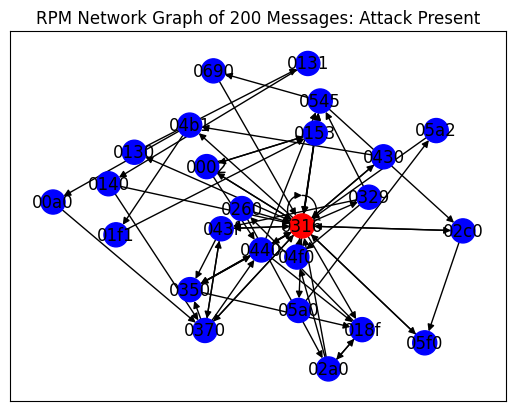

In [116]:
layouts = {'spring' : nx.spring_layout(G, k=1),
           'spiral': nx.spiral_layout(G),
           'spectral': nx.spectral_layout(G),
           'random': nx.random_layout(G),
           'circle': nx.circular_layout(G),
           }


nx.draw_networkx(G, pos=layouts['spring'], with_labels = True, node_color= label_colors.values())
plt.title("RPM Network Graph of 200 Messages: Attack Present")

plt.show()

In [ ]:
'''   
- Turn the graph into a pytorch geometric dataset
- simple training with a basic GNN
'''